# Prepare data for grid network

In [1]:
import numpy as np
# import torch
# import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib
import os

In [41]:
def g(n): #n!
    res = [1]
    for i in range(2,n+1):
        res.append(i * res[-1])
    return np.array(res)

def f(x): # ln(x)/n!n
    n = np.arange(1, 20)
    return n, ((np.log(x))**n)/g(n[-1])/n

In [68]:
x = range(1, 100000, 100)
y = [np.sum(f(i)[1]) for i in x] # Sn

In [71]:
(100000*y[-1] - 50000*y[len(y)//2])/y[-1] /100000

0.7306165547223529

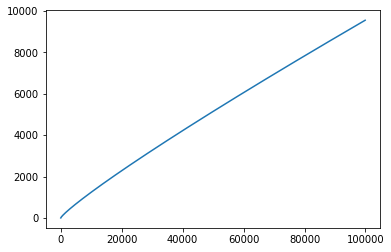

In [72]:
plt.plot(x,y)

In [134]:
# set random seed
np.random.seed(42)

In [135]:
matplotlib.rcParams.update({
    'figure.dpi': 300,
    'figure.titlesize': 25,
    'axes.titlesize': 15,
    'axes.labelsize': 13,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 13,
    'legend.title_fontsize': 15
})

In [136]:
def get_peak_rate(peaktime, peaktime2, T=60*24):
    res = []
    lamb = list(np.arange(0,1,1/(peaktime2-peaktime))) + list(np.arange(1,0,-1/(T-(peaktime2-peaktime))))
    lamb = lamb[(T-peaktime):] + lamb[:(T-peaktime)] 
    for t in range(T):
        if(t<peaktime):
            res.append(1- 1/peaktime * (peaktime - t))
        elif(t>=peaktime and t<peaktime2):
            res.append(1)
        else:
            res.append(1 - 1/(T-peaktime2) * (t - peaktime2))
    return np.array(res).clip(min=0.6), np.array(lamb)

# Grid networks with static demand

In [137]:
# Prepare data on a small grid, assume a Poisson process of passenger arrival 
# Its mean randomly generated over a set of selections
# Number of vehicles = n^2/2
# Total passenger arrival rates = n/2 
for grid_size in [3,4,5]:
    for instance_id in range(10):
        if not os.path.isdir('grid_small_static/'+str(grid_size)+'/'+str(instance_id)):
            os.makedirs('grid_small_static/'+str(grid_size)+'/'+str(instance_id))

for grid_size in [3,4,5]:
    
    node_size = grid_size ** 2

    travel_distance = np.zeros((node_size, node_size))

    for i in range(grid_size):
        for j in range(grid_size):
            for i2 in range(grid_size):
                for j2 in range(grid_size):
                    travel_distance[i*grid_size+j, i2*grid_size+j2] = abs(i2-i)+abs(j2-j)

    travel_time = travel_distance

    train_T = 10080
    test_T = 10080

    num_veh = node_size
    pass_rate = grid_size

    # the expected income per unit time of the system is pass_rate * avg_distance/ num_veh * profit

    for instance_id in range(10):
        dd_train = np.zeros((train_T, node_size, node_size))
        dd_test = np.zeros((test_T, node_size, node_size))
        dp_train = np.ones((train_T, node_size, node_size)) * 0.8
        # if(instance_id == 0):
        vp = np.random.normal(1, 1, size = num_veh)
        # else:
        #     vp = np.random.lognormal(mean = 0, sigma= 0.25, size = num_veh)

        weights = np.array([j%grid_size+j//grid_size for j in range(node_size)])
        for j in range(node_size):
            dd_train[:,j,:] = pass_rate * weights[j]/ (sum(weights)) / (node_size-1)
            dd_train[:,j,j] = 0 
            # tmp_train = np.sqrt(dd_train[:,j,:])
            # dp_train[:,j,:] *= tmp_train
            dd_test[:,j,:] = np.random.poisson(dd_train[:,j,:]).astype(int)


        np.save('grid_small_static/'+str(grid_size)+'/'+str(instance_id)+'/td.npy', travel_distance)
        np.save('grid_small_static/'+str(grid_size)+'/'+str(instance_id)+'/tt.npy', travel_time)
        np.save('grid_small_static/'+str(grid_size)+'/'+str(instance_id)+'/vp.npy', vp)
        np.save('grid_small_static/'+str(grid_size)+'/'+str(instance_id)+'/dd_train.npy', dd_train)
        np.save('grid_small_static/'+str(grid_size)+'/'+str(instance_id)+'/dd_test.npy', dd_test)

        res = np.zeros((grid_size,grid_size))
        for i in range(node_size):
            res[i//grid_size, i %grid_size] = i

        m = grid_size
        n = grid_size

        old_res = [[] for i in range(node_size)]

        for i in range(node_size):
            for j in range(node_size):
                old_res[i].append((i, j))

        new_res = [[] for i in range(int(m**2))]

        for i in range(int(m**2)):
            for j in range(int(n**2)):
                new_res[i].append([])

        i = 0
        for i1 in range(int(m)):
            for j1 in range(int(n)):
                for i2 in range(int(m)):
                    for j2 in range(int(n)):
                        i+=1
                        new_res[i1 * m + i2 % m][j1 *n + j2 %n].append((int(res[i1,j1]),int(res[i2,j2])))

        new_res2 = [[] for i in range(int(m**2))] # arrival permutation

        for i in range(int(m**2)):
            for j in range(int(n**2)):
                new_res2[i].append([])

        i = 0
        for i1 in range(int(m)):
            for j1 in range(int(n)):
                for i2 in range(int(m)):
                    for j2 in range(int(n)):
                        i+=1
                        new_res2[i1 % m + i2 * m][j1 %n + j2 *n].append((int(res[i1,j1]),int(res[i2,j2])))

        # row_index 
        # col_index
        row_index = np.zeros(node_size**2,dtype=int)
        col_index = np.zeros(node_size**2,dtype=int)
        for i in range(int(m**2)):
            for j in range(int(n**2)):
                for (source, target) in new_res[i][j]:
                    row_index[source * node_size + target] = i
                    col_index[source * node_size + target] = j

        row_index2 = np.zeros(node_size**2,dtype=int)
        col_index2 = np.zeros(node_size**2,dtype=int)
        for i in range(int(m**2)):
            for j in range(int(n**2)):
                for (source, target) in new_res2[i][j]:
                    row_index2[source * node_size + target] = i
                    col_index2[source * node_size + target] = j

        if not os.path.isdir('grid_small_static/'+str(grid_size)+'/'+str(instance_id)):
            os.makedirs('grid_small_static/'+str(grid_size)+'/'+str(instance_id))
        np.save('grid_small_static/'+str(grid_size)+'/'+str(instance_id)+'/permutation.npy', [row_index, col_index])
        np.save('grid_small_static/'+str(grid_size)+'/'+str(instance_id)+'/permutation2.npy', [row_index2, col_index2])

# Grid networks with time varied demand

In [138]:
rate, lamb = get_peak_rate(8*60, 18*60)

In [139]:
rate = list(rate)*7
rate = np.array(rate)
lamb = list(lamb)*7
lamb = np.array(lamb)

$\lambda$: parameters for the intensity distribution of the demand
\
$\omega$: parameters for the level (multiplier) of the total demand

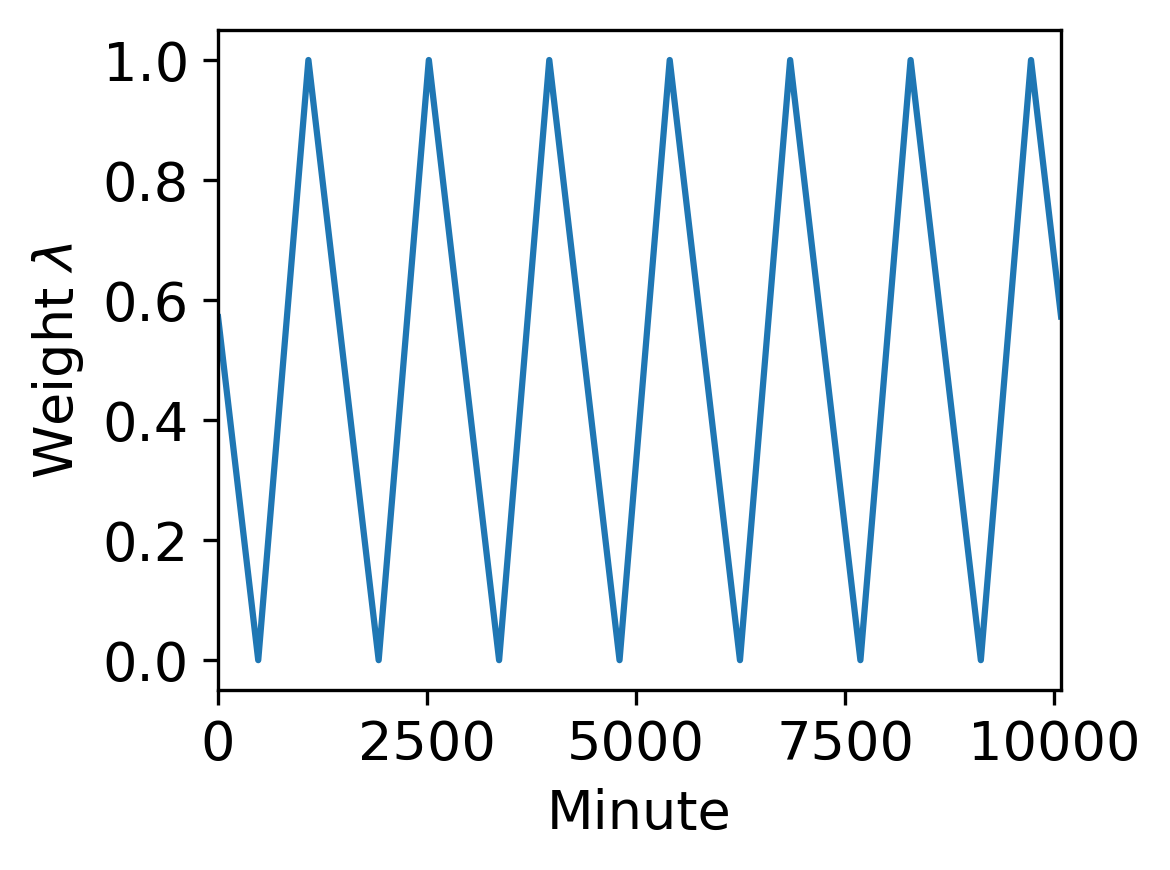

In [140]:
plt.subplots(figsize=(4,3))

plt.plot(lamb)
plt.ylabel("Weight $\lambda$")
plt.xlabel("Minute")
plt.xlim([0,10080])
plt.ylim([-0.05,1.05])
plt.tight_layout()
plt.savefig('figs/small_weight.png')
plt.savefig('figs/small_weight.pdf')

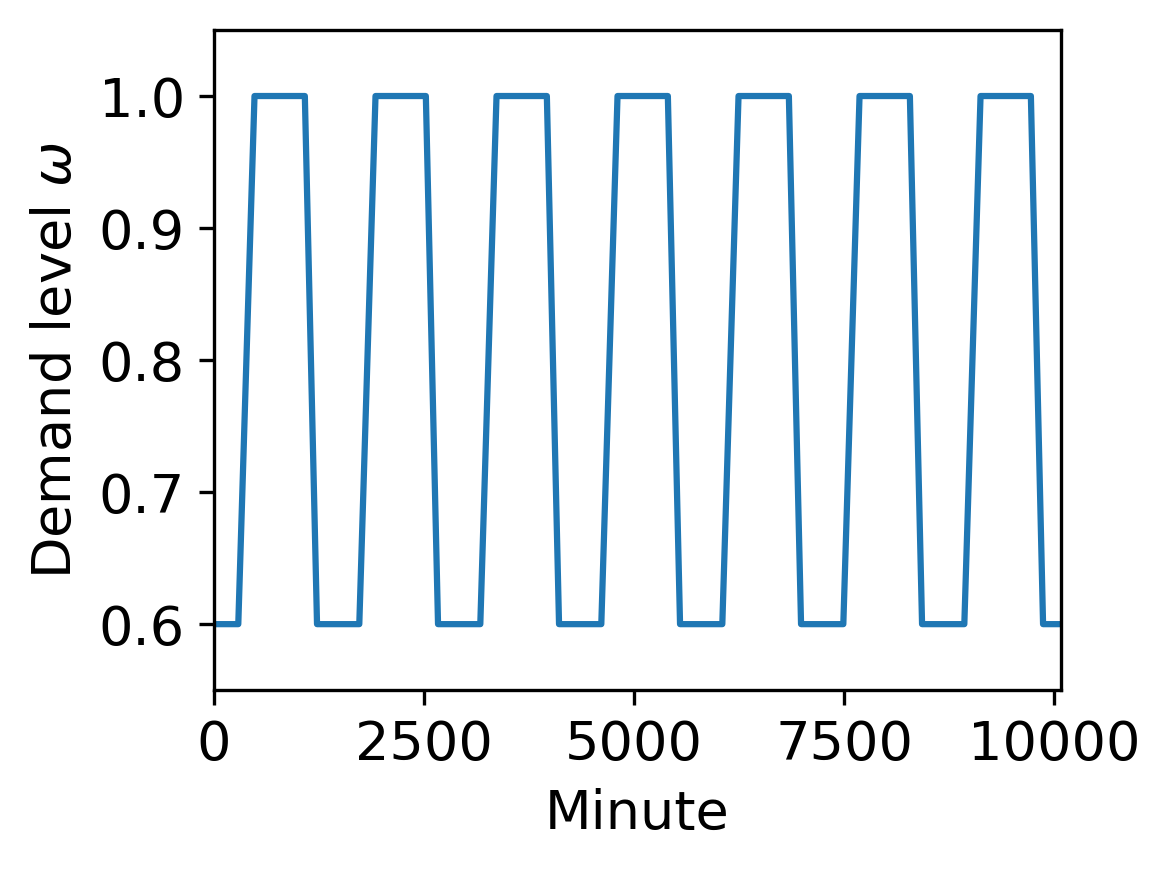

In [141]:
plt.subplots(figsize=(4,3))

plt.plot(rate)

plt.ylabel("Demand level $\omega$")
plt.xlabel("Minute")
plt.xlim([0,10080])
plt.ylim([0.55,1.05])
plt.tight_layout()
plt.savefig('figs/small_level.png')
plt.savefig('figs/small_level.pdf')

In [142]:
# Prepare data on a small grid, assume a Poisson process of passenger arrival 
# Its mean randomly generated over a set of selections
# Number of vehicles = n^2/2
# Total passenger arrival rates = n/2 
for grid_size in [3,4,5]:
    for instance_id in range(10):
        if not os.path.isdir('grid_small_dynamic/'+str(grid_size)+'/'+str(instance_id)):
            os.makedirs('grid_small_dynamic/'+str(grid_size)+'/'+str(instance_id))
            
for grid_size in [3,4,5]:
        node_size = grid_size ** 2

        travel_distance = np.zeros((node_size, node_size))

        for i in range(grid_size):
            for j in range(grid_size):
                for i2 in range(grid_size):
                    for j2 in range(grid_size):
                        travel_distance[i*grid_size+j, i2*grid_size+j2] = abs(i2-i)+abs(j2-j)

        travel_time = travel_distance

        train_T = 10080
        test_T = 10080

        num_veh = node_size
        pass_rate = grid_size

        # the expected income per unit time of the system is pass_rate * avg_distance/ num_veh * profit

        for instance_id in range(10):
            dd_train = np.zeros((train_T, node_size, node_size))
            dd_test = np.zeros((test_T, node_size, node_size))
            dp_train = np.ones((train_T, node_size, node_size)) * 0.8
            # if(instance_id == 0):
            vp = np.random.normal(np.sum(rate)/10800, 1, size = num_veh) # np.sum(rate)/10800 relative demand rate per day
            # else:
            # vp = np.random.lognormal(mean = 0, sigma= 0.25, size = num_veh)

            weights = np.array([j%grid_size+j//grid_size for j in range(node_size)])
            weights2 = (np.max(weights)- np.array(weights))
            for j in range(node_size):
                dd_train[:,j,:] = pass_rate * ((1-lamb)[:,None]*weights[j]+lamb[:,None]*weights2[j])/ (sum(weights)) / (node_size-1)
                dd_train[:,j,j] = 0 
                dd_train[:,j,:] *= rate[:,None]
                # tmp_train = np.sqrt(dd_train[:,j,:])
                # dp_train[:,j,:] *= tmp_train
                dd_test[:,j,:] = np.random.poisson(dd_train[:,j,:]).astype(int)


            np.save('grid_small_dynamic/'+str(grid_size)+'/'+str(instance_id)+'/td.npy', travel_distance)
            np.save('grid_small_dynamic/'+str(grid_size)+'/'+str(instance_id)+'/tt.npy', travel_time)
            np.save('grid_small_dynamic/'+str(grid_size)+'/'+str(instance_id)+'/vp.npy', vp)
            # np.save('grid_small_dynamic/'+str(grid_size)+'/'+str(instance_id)+'/dp_train.npy', dp_train)
            np.save('grid_small_dynamic/'+str(grid_size)+'/'+str(instance_id)+'/dd_train.npy', dd_train)
            np.save('grid_small_dynamic/'+str(grid_size)+'/'+str(instance_id)+'/dd_test.npy', dd_test)

            res = np.zeros((grid_size,grid_size))
            for i in range(node_size):
                res[i//grid_size, i %grid_size] = i

            m = grid_size
            n = grid_size

            old_res = [[] for i in range(node_size)]

            for i in range(node_size):
                for j in range(node_size):
                    old_res[i].append((i, j))

            new_res = [[] for i in range(int(m**2))]

            for i in range(int(m**2)):
                for j in range(int(n**2)):
                    new_res[i].append([])

            i = 0
            for i1 in range(int(m)):
                for j1 in range(int(n)):
                    for i2 in range(int(m)):
                        for j2 in range(int(n)):
                            i+=1
                            new_res[i1 * m + i2 % m][j1 *n + j2 %n].append((int(res[i1,j1]),int(res[i2,j2])))

            new_res2 = [[] for i in range(int(m**2))] # arrival permutation

            for i in range(int(m**2)):
                for j in range(int(n**2)):
                    new_res2[i].append([])

            i = 0
            for i1 in range(int(m)):
                for j1 in range(int(n)):
                    for i2 in range(int(m)):
                        for j2 in range(int(n)):
                            i+=1
                            new_res2[i1 % m + i2 * m][j1 %n + j2 *n].append((int(res[i1,j1]),int(res[i2,j2])))

            # row_index 
            # col_index
            row_index = np.zeros(node_size**2,dtype=int)
            col_index = np.zeros(node_size**2,dtype=int)
            for i in range(int(m**2)):
                for j in range(int(n**2)):
                    for (source, target) in new_res[i][j]:
                        row_index[source * node_size + target] = i
                        col_index[source * node_size + target] = j

            row_index2 = np.zeros(node_size**2,dtype=int)
            col_index2 = np.zeros(node_size**2,dtype=int)
            for i in range(int(m**2)):
                for j in range(int(n**2)):
                    for (source, target) in new_res2[i][j]:
                        row_index2[source * node_size + target] = i
                        col_index2[source * node_size + target] = j

            np.save('grid_small_dynamic/'+str(grid_size)+'/'+str(instance_id)+'/permutation.npy', [row_index, col_index])
            np.save('grid_small_dynamic/'+str(grid_size)+'/'+str(instance_id)+'/permutation2.npy', [row_index2, col_index2])

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [144]:
grid_size = 5

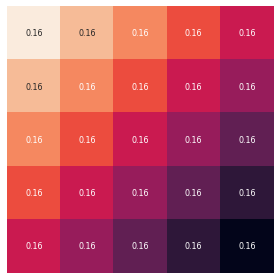

In [145]:
plt.subplots(figsize=(4,4))
mat = np.sum(dd_train, axis = (0,2)).reshape((grid_size, grid_size))/train_T
sns.heatmap(mat, annot=mat, annot_kws={'fontsize': 8}, cbar = False, cmap='rocket_r')
plt.xticks([])
plt.yticks([])

plt.tight_layout()

plt.savefig('figs/small_grid_'+str(grid_size)+'.png')
plt.savefig('figs/small_grid_'+str(grid_size)+'.pdf')

In [146]:
import numpy as np

a = np.array([1,2,3])
np.argmax(a)

2

In [147]:
vp = np.load('grid_small_static/3/0/vp.npy')
vp

array([1.49671415, 0.8617357 , 1.64768854, 2.52302986, 0.76584663,
       0.76586304, 2.57921282, 1.76743473, 0.53052561])

In [148]:
vp = np.load('grid_small_dynamic/3/0/vp.npy')
vp

array([0.22575762, 1.43569   , 2.67660257, 0.95101361, 1.1834614 ,
       0.48471291, 0.91518562, 1.3572856 , 2.13485792])

(array([1., 1., 2., 1., 2., 0., 0., 1., 0., 1.]),
 array([0.22575762, 0.47084211, 0.71592661, 0.9610111 , 1.2060956 ,
        1.45118009, 1.69626459, 1.94134908, 2.18643358, 2.43151807,
        2.67660257]),
 <BarContainer object of 10 artists>)

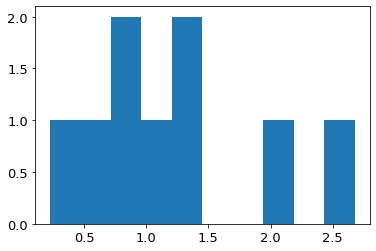

In [149]:
plt.hist(vp)